In [0]:
%cd /content/drive/Shared\ drives/CS230 
%cd google_action_recognition_trial

/content/drive/Shared drives/CS230
/content/drive/Shared drives/CS230/google_action_recognition_trial


In [0]:
# This cell is for temporary code consolidation
%cp ../google_action_recognition_trial/evanet/run* ./evanet/

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv3D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras.initializers import VarianceScaling
import keras.backend as K
from keras.backend import mean
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import os

Using TensorFlow backend.


In [0]:
def to_one_hot(labels):
  output = np.zeros(( np.size(labels),6 ))
  label_dict = {'backhand':0,'forehand':1, 'bvolley':2, 'fvolley':3, 'smash':4, 'service':5}
  for n in np.arange(np.size(labels)):
    label = labels[n]
    output[n, label_dict[label]] = 1
  return output 

In [0]:
import csv

def create_data(dataset='train',size=198):
  data = np.zeros([size,1,7,7,2048])
  labels = []
  with open('evanet/data/data_file_1.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/1/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2048)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1

  with h5py.File(dataset+'_1.hdf5', 'w') as f:
    write_data = f.create_dataset('X', np.shape(data))
    write_data[:] = data 

def load_one_hot_labels(dataset='train',size=198):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return to_one_hot(labels)

def load_text_labels(dataset='train',size=198):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return labels

def load_data(dataset='train', size=198):
  with h5py.File(dataset+'.hdf5', 'r') as f:
    data = np.array(f['X'])[0:size]
    default_size = data.shape[0]
  labels_one_hot = load_one_hot_labels(dataset=dataset,size=size)

  return data, labels_one_hot


def create_small_dataset(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2048])
  labels = []
  with open('evanet/data/data_file_1.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/1/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2048)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1
  return data, to_one_hot(labels)

In [0]:
# create_data(dataset='test',size=192)
# create_data(dataset='validation',size=204)
# create_data(dataset='train',size=1584)

In [0]:
X, Y = load_data(dataset='validation',size=204)
for i in np.arange(198):
  if np.linalg.norm(X[i]) == 0:
    print('Zero')

Finding cluster distance

In [0]:
def centroid(a):
  num_data, dim_data = np.shape(a)
  

SyntaxError: ignored

In [0]:
#Dataset 1
labels = ['backhand', 'forehand', 'bvolley', 'fvolley', 'smash', 'service']
L = np.array(load_text_labels(dataset='test', size=192))
Z = np.array([X_test[i].flatten() for i in np.arange(192)])
mean_index = np.zeros((6,100352))
k = 0
for label in labels:
  indices = np.where(L == label)
  Z_label = Z[indices]
  mean_index[k] = np.mean(Z_label, axis=0, keepdims=True)
  k+= 1

for s in np.arange(1, 6):
  for t in np.arange(s):
    distance = np.linalg.norm(mean_index[s] - mean_index[t])/ np.sqrt( np.linalg.norm(mean_index[s]) * np.linalg.norm(mean_index[t]) )
    print('Distance between ' + str(labels[t]) + ' and ' + str(labels[s]) + ': ' + str(distance*100))

Distance between backhand and forehand: 10.271630089085736
Distance between backhand and bvolley: 24.429467907602987
Distance between forehand and bvolley: 23.251202825894453
Distance between backhand and fvolley: 23.74896852421965
Distance between forehand and fvolley: 19.29877283109069
Distance between bvolley and fvolley: 25.849116856713383
Distance between backhand and smash: 26.09256242937721
Distance between forehand and smash: 20.73303729147233
Distance between bvolley and smash: 27.348855492469227
Distance between fvolley and smash: 25.881188912464275
Distance between backhand and service: 22.950504670408804
Distance between forehand and service: 19.548779962878367
Distance between bvolley and service: 32.86433154564611
Distance between fvolley and service: 31.91019538812589
Distance between smash and service: 19.727763987404693


In [0]:
#Dataset 0
P_test, Q_test = load_data(dataset='test',size=192)
labels = ['backhand', 'forehand', 'bvolley', 'fvolley', 'smash', 'service']
L = np.array(load_text_labels(dataset='test', size=192))
Z = np.array([P_test[i].flatten()*1000 for i in np.arange(192)])
mean_index = np.zeros((6,100254))
k = 0
for label in labels:
  indices = np.where(L == label)
  Z_label = Z[indices]
  mean_index[k] = np.mean(Z_label, axis=0, keepdims=True)
  k+= 1
  
for s in np.arange(1, 6):
  for t in np.arange(s):
    distance = np.linalg.norm(mean_index[s] - mean_index[t])/ np.sqrt( np.linalg.norm(mean_index[s]) * np.linalg.norm(mean_index[t])  )
    print('Distance between ' + str(labels[t]) + ' and ' + str(labels[s]) + ': ' + str(distance*100))

Distance between backhand and forehand: 2.8338849712374174
Distance between backhand and bvolley: 5.335682509921556
Distance between forehand and bvolley: 4.335228756820503
Distance between backhand and fvolley: 10.754650265058553
Distance between forehand and fvolley: 10.372099356679607
Distance between bvolley and fvolley: 10.082716923180659
Distance between backhand and smash: 4.780778003354069
Distance between forehand and smash: 4.471494242799267
Distance between bvolley and smash: 3.5083392236434077
Distance between fvolley and smash: 9.335881880347177
Distance between backhand and service: 9.580303096009878
Distance between forehand and service: 8.958705408063514
Distance between bvolley and service: 8.694689267200811
Distance between fvolley and service: 18.057791226648888
Distance between smash and service: 9.5953141091814


In [0]:
X_test.shape

(192, 1, 7, 7, 2048)

Final version model on dataset 1

In [0]:
X_train, Y_train = load_data(dataset='train', size=1584)
X_val, Y_val = load_data(dataset='validation',size=204)
X_test, Y_test = load_data(dataset='test',size=192)

In [0]:
# Train network
dropout_rate=0.3
m=0.01
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(128,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  X = Reshape((128,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(128)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(64)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(32)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=preds)
  return model 

In [0]:
model = model_instance(input_shape=(1,7,7,2048))
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 7, 7, 2048)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 1, 1, 1, 128)      12845184  
_________________________________________________________________
reshape_5 (Reshape)          (None, 128)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
activation_21 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1651

In [0]:
if not os.path.exists('Checkpoints'):
    os.mkdir('Checkpoints')
opt=Adam()
checkpoint = ModelCheckpoint(os.path.join('Checkpoints','weights_dataset1_dr03_m001_newer.hdf5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model.load_weights(os.path.join('Checkpoints','weights_dataset1_dr03_m001_newer.hdf5'))
model.fit(X_train, Y_train, epochs = 500, batch_size=128,callbacks=[checkpoint],validation_data=(X_val,Y_val), shuffle=True, validation_freq=1)

Train on 1584 samples, validate on 204 samples
Epoch 1/500
1584/1584 [==============================] - 3s 2ms/step - loss: 0.0670 - categorical_accuracy: 0.9766 - val_loss: 1.2885 - val_categorical_accuracy: 0.7794

Epoch 00001: val_categorical_accuracy improved from -inf to 0.77941, saving model to Checkpoints/weights_dataset1_dr03_m001_newer.hdf5
Epoch 2/500
1584/1584 [==============================] - 1s 463us/step - loss: 0.0661 - categorical_accuracy: 0.9792 - val_loss: 1.4585 - val_categorical_accuracy: 0.7794

Epoch 00002: val_categorical_accuracy improved from 0.77941 to 0.77941, saving model to Checkpoints/weights_dataset1_dr03_m001_newer.hdf5
Epoch 3/500
1584/1584 [==============================] - 1s 471us/step - loss: 0.0682 - categorical_accuracy: 0.9766 - val_loss: 1.3636 - val_categorical_accuracy: 0.8186

Epoch 00003: val_categorical_accuracy improved from 0.77941 to 0.81863, saving model to Checkpoints/weights_dataset1_dr03_m001_newer.hdf5
Epoch 4/500
1584/1584 [=====

In [0]:
opt=Adam()
model.load_weights(os.path.join('Checkpoints','weights_dataset1_dr03_m001_newer.hdf5'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.evaluate(X_train,Y_train))
print(model.evaluate(X_val,Y_val))
print(model.evaluate(X_test,Y_test))

1584/1584 [==============================] - 1s 556us/step
[0.004280151370554137, 1.0]
204/204 [==============================] - 0s 269us/step
[1.0596045840020274, 0.8333333333333334]
192/192 [==============================] - 0s 247us/step
[1.6362652809669573, 0.78125]


              precision    recall  f1-score   support

    backhand       0.90      0.75      0.82        48
    forehand       0.72      0.88      0.79        48
     bvolley       0.79      0.94      0.86        16
     fvolley       0.73      0.50      0.59        16
       smash       0.71      0.31      0.43        16
     service       0.81      0.96      0.88        48

    accuracy                           0.79       192
   macro avg       0.78      0.72      0.73       192
weighted avg       0.79      0.79      0.78       192



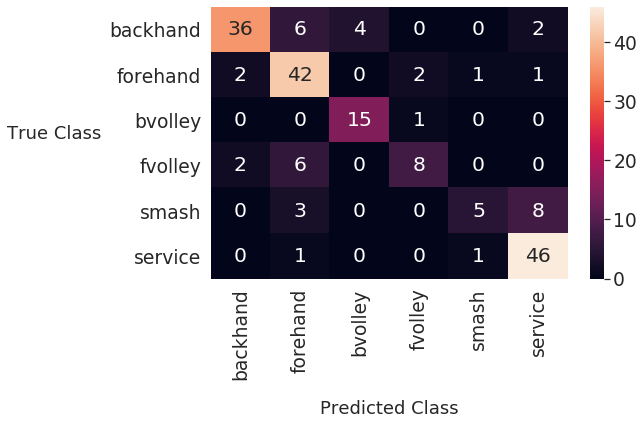

In [0]:
Y_probs=model.predict(X_test)
Y_pred=np.argmax(Y_probs,axis=1)
Y_test_cat=np.argmax(Y_test,axis=1)
target_names = ['backhand', 'forehand', 'bvolley', 'fvolley', 
                   'smash', 'service']
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(Y_test_cat, Y_pred, target_names=target_names))
conf_matrix = confusion_matrix(Y_test_cat, Y_pred)
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.7)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.savefig('confusion_matrix_1.jpg', bbox_inches = 'tight')
plt.show()